In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import glob
import itertools
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import random
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt
import os

In [7]:
import json

with open('models/errors.json', 'r') as file:
    errors = json.load(file)
    
with open('models/val_errors.json', 'r') as file:
    val_errors = json.load(file)

In [42]:
val_errors['0']['val_loss']

2.709395408630371

In [45]:
G = []

G = [i['val_loss'] for i in val_errors.values()]
ssim = [i['ssim'] for i in val_errors.values()]
        

In [32]:
import matplotlib.pyplot as plt

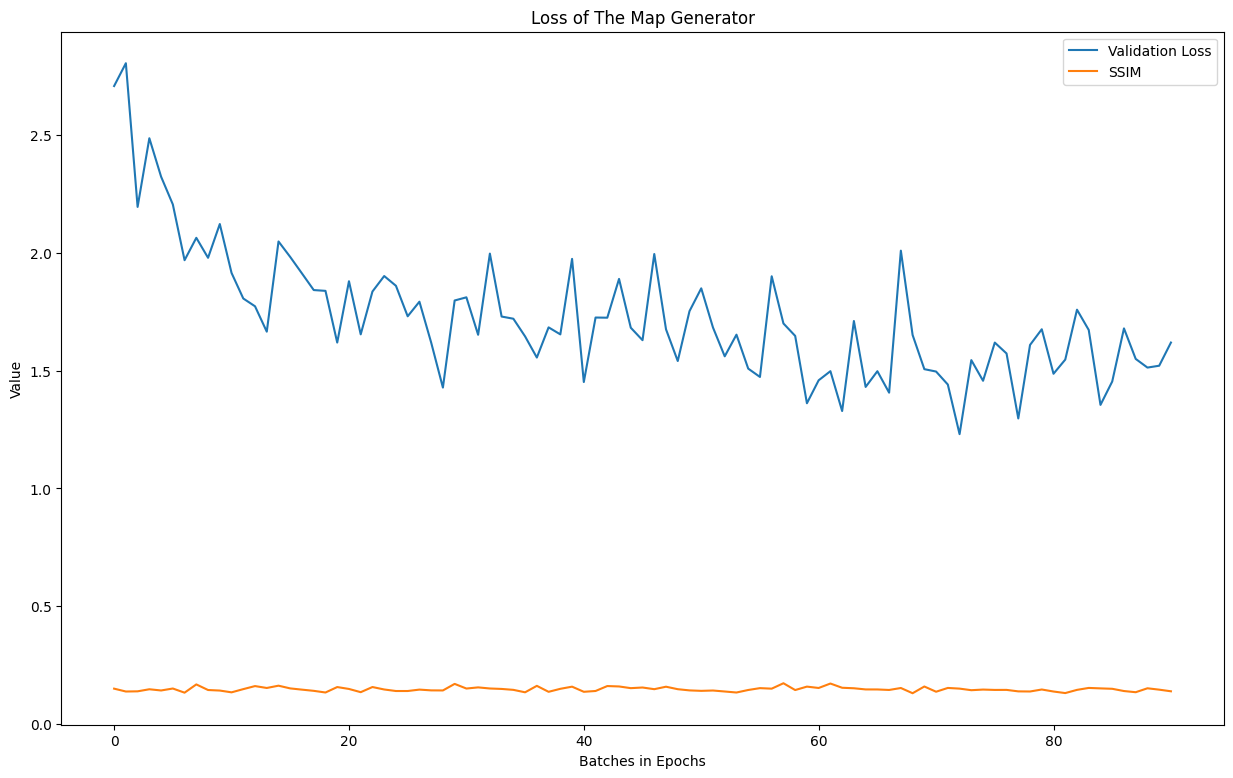

In [48]:
plt.figure(figsize=(15, 9))

plt.plot(G, label="Validation Loss")
plt.plot(ssim, label="SSIM")

plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Validation of The Map Generator')
plt.legend()

In [4]:
from torchviz import make_dot
from generator import Generator
from discriminator import Discriminator
from device import Device
import torch

# Initialize device and model parameters
device = Device().device
input_channels = 3
output_channels = 3

# Initialize models
G_A = Generator(input_channels, output_channels).to(device)
G_B = Generator(input_channels, output_channels).to(device)
D_A = Discriminator(input_channels).to(device)
D_B = Discriminator(input_channels).to(device)

# Create dummy inputs for plotting
dummy_input_G = torch.randn(1, input_channels, 256, 256, device=device)
dummy_input_D = torch.randn(1, input_channels, 256, 256, device=device)

# Plot the models
plot_G_A = make_dot(G_A(dummy_input_G), params=dict(G_A.named_parameters()), show_attrs=True, show_saved=True)
plot_G_B = make_dot(G_B(dummy_input_G), params=dict(G_B.named_parameters()), show_attrs=True, show_saved=True)
plot_D_A = make_dot(D_A(dummy_input_D), params=dict(D_A.named_parameters()), show_attrs=True, show_saved=True)
plot_D_B = make_dot(D_B(dummy_input_D), params=dict(D_B.named_parameters()), show_attrs=True, show_saved=True)

# Save the plots to files
plot_G_A.render("plot_G_A")
plot_G_B.render("plot_G_B")
plot_D_A.render("plot_D_A")
plot_D_B.render("plot_D_B")


Is CUDA available:  True
Number of GPUs available:  1
GPU Name:  NVIDIA GeForce RTX 3060 Laptop GPU


'plot_D_B.pdf'

In [2]:
print("Is CUDA available: ", torch.cuda.is_available())
print("Number of GPUs available: ", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU Name: ", torch.cuda.get_device_name(0))
    
# Move models to GPU
device = torch.device('cuda')

Is CUDA available:  True
Number of GPUs available:  1
GPU Name:  NVIDIA GeForce RTX 3060 Laptop GPU


In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, input_channels, output_channels, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution block
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_channels, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]

        # Downsampling
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features*2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features//2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features//2

        # Output layer
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, output_channels, 7),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self, input_channels):
        super(Discriminator, self).__init__()

        # A series of convolutions to downsample the image
        model = [
            nn.Conv2d(input_channels, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        ]

        model += [
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128), 
            nn.LeakyReLU(0.2, inplace=True)
        ]

        model += [
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256), 
            nn.LeakyReLU(0.2, inplace=True)
        ]

        model += [
            nn.Conv2d(256, 512, 4, padding=1),
            nn.InstanceNorm2d(512), 
            nn.LeakyReLU(0.2, inplace=True)
        ]

        # Final convolution without instance normalization
        model += [nn.Conv2d(512, 1, 4, padding=1)]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        x = self.model(x)
        return x
    
    def compute_output_shape(self, input_height, input_width):
        # Forward a dummy input through the discriminator to get the output shape
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, input_height, input_width, device=self.device)
            output = self(dummy_input)
        return output.size()[2:]  # return only the height and width
    
class SatelliteToMapDataset(Dataset):
    def __init__(self, root_dir, transform=None, resize=None):
        self.file_list = glob.glob(root_dir + '/*.jpg')
        self.transform = transform
        self.resize = resize

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img = Image.open(self.file_list[idx])
        w, h = img.size

        # Resize the image if it's too large
        if self.resize != None:
            if w > self.resize or h > self.resize:
                img = transforms.Resize(self.resize)(img)
                w, h = img.size

        img_A = img.crop((0, 0, w / 2, h))  # Satellite image
        img_B = img.crop((w / 2, 0, w, h))  # Map image

        if self.transform:
            img_A = self.transform(img_A)
            img_B = self.transform(img_B)

        return {'satellite_image': img_A, 'map_image': img_B}

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [4]:
# Adversarial Loss
def adversarial_loss(output, target_is_real):
    target = torch.ones_like(output) if target_is_real else torch.zeros_like(output)
    return nn.MSELoss()(output, target)

# Cycle Consistency Loss
def cycle_consistency_loss(real_image, reconstructed_image, lambda_cycle=10):
    return lambda_cycle * nn.L1Loss()(real_image, reconstructed_image)

# Identity Loss (Optional)
def identity_loss(real_image, same_image, lambda_identity=5):
    return lambda_identity * nn.L1Loss()(real_image, same_image)


In [5]:
class ImageBuffer:
    def __init__(self, buffer_size=50):
        self.buffer_size = buffer_size
        self.num_images = 0
        self.images = []

    def get_images(self, images):
        to_return = []
        for image in images:
            image = torch.unsqueeze(image.data, 0)
            if self.num_images < self.buffer_size:
                self.images.append(image)
                self.num_images += 1
                to_return.append(image)
            else:
                if random.uniform(0, 1) > 0.5:
                    random_id = random.randint(0, self.buffer_size - 1)
                    tmp = self.images[random_id].clone()
                    self.images[random_id] = image
                    to_return.append(tmp)
                else:
                    to_return.append(image)
        return torch.cat(to_return, 0)


In [6]:
# Assuming the number of channels for input and output images
input_channels = 3  # For example, RGB images
output_channels = 3  # Adjust if different for your case

# Create the generator and discriminator instances
G_A = Generator(input_channels, output_channels)  # Generator A to B
G_B = Generator(input_channels, output_channels)  # Generator B to A
D_A = Discriminator(input_channels)  # Discriminator A
D_B = Discriminator(input_channels)  # Discriminator B

G_A.to(device)
G_B.to(device)
D_A.to(device)
D_B.to(device)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

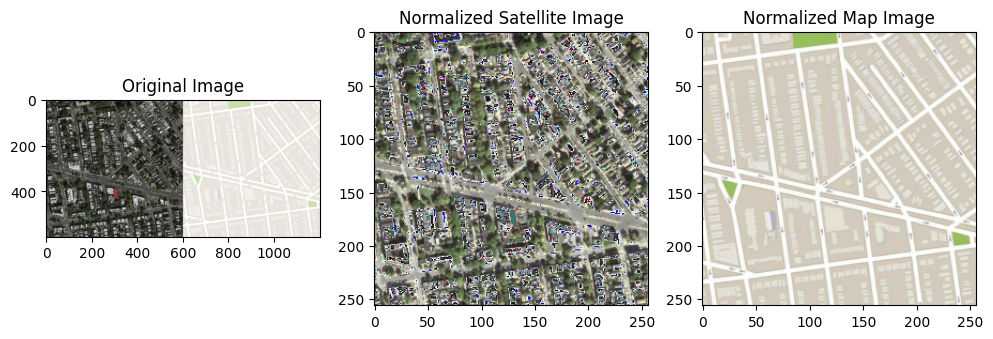

In [7]:
def test_dataset_functionality(dataset, index=0):
    # Get the images from the dataset
    sample = dataset[index]
    satellite_image = sample['satellite_image']
    map_image = sample['map_image']

    # Convert to NumPy and change to channels-last format
    satellite_image_np = transforms.ToPILImage()(satellite_image).convert("RGB")
    map_image_np = transforms.ToPILImage()(map_image).convert("RGB")
    
    # Display the original image
    original_img = Image.open(dataset.file_list[index])
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title('Original Image')

    # Display the left part of the image (satellite image)
    plt.subplot(1, 3, 2)
    plt.imshow(satellite_image_np)
    plt.title('Normalized Satellite Image')

    # Display the right part of the image (map image)
    plt.subplot(1, 3, 3)
    plt.imshow(map_image_np)
    plt.title('Normalized Map Image')

    plt.show()

# Example usage
dataset = SatelliteToMapDataset(root_dir='./data/maps/maps/train/train/', transform=transform, resize=256)
test_dataset_functionality(dataset, 0)

In [8]:
# Create a dataloader
batch_size = 2  # You can change this depending on your GPU memory
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)

In [9]:
# Assuming G_A and G_B are your generators, and D_A and D_B are your discriminators
optimizer_G = optim.Adam(itertools.chain(G_A.parameters(), G_B.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_A = optim.Adam(D_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [10]:
from IPython.display import clear_output

In [11]:
scaler = GradScaler()
num_epochs = 1000  # Define the number of epochs
accumulation_steps = 8
fake_A_buffer = ImageBuffer()
fake_B_buffer = ImageBuffer()

errors = {}

def save_plots(real_A, real_B, fake_A, fake_B, epoch, batch_index):
    # Function to convert tensor to numpy image
    def to_numpy(tensor):
        # Normalize to [0, 1] and then scale to [0, 255]
        tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())
        image = tensor.detach().cpu().numpy().transpose(1, 2, 0)
        image = (image * 255).astype(np.uint8)
        return image

    fig, axs = plt.subplots(2, 2, figsize=(8, 8))

    # Normalize and plot real_A
    image = to_numpy(real_A)
    image = (image - image.min()) / (image.max() - image.min())
    axs[0, 0].imshow(image)
    axs[0, 0].set_title("Real A")
    axs[0, 0].axis('off')

    # Normalize and plot fake_A
    image = to_numpy(fake_A)
    image = (image - image.min()) / (image.max() - image.min())
    axs[0, 1].imshow(image)
    axs[0, 1].set_title("Fake A")
    axs[0, 1].axis('off')

    # Normalize and plot real_B
    image = to_numpy(real_B)
    image = (image - image.min()) / (image.max() - image.min())
    axs[1, 0].imshow(image)
    axs[1, 0].set_title("Real B")
    axs[1, 0].axis('off')

    # Normalize and plot fake_B
    image = to_numpy(fake_B)
    image = (image - image.min()) / (image.max() - image.min())
    axs[1, 1].imshow(image)
    axs[1, 1].set_title("Fake B")
    axs[1, 1].axis('off')

    plt.tight_layout()
    plt.savefig(f'plots/epoch_{epoch}_batch_{batch_index}.png')
    plt.savefig(f'last_map_generated.png')
    plt.close()

# Ensure the directory for plots exists
os.makedirs('plots', exist_ok=True)

for epoch in range(num_epochs):
    
    epoch_errors_g = {}
    epoch_errors_d_a = {}
    epoch_errors_d_b = {}
    
    for i, batch in enumerate(dataloader):
        
        clear_output(wait=True)
        
        print(f"Epoch: {epoch}")
        print(f"    Batch: {i}")
        
        real_A = batch['satellite_image'].to(device)
        real_B = batch['map_image'].to(device)

        ######################
        # Update Generators
        ######################
        optimizer_G.zero_grad()

        with autocast():
            # Generate fake images
            fake_B = G_A(real_A)
            fake_A = G_B(real_B)

            # Identity loss (optional)
            loss_identity_A = identity_loss(G_B(real_A), real_A)
            loss_identity_B = identity_loss(G_A(real_B), real_B)

            # GAN loss
            loss_GAN_A2B = adversarial_loss(D_B(fake_B), True)  # True for real label
            loss_GAN_B2A = adversarial_loss(D_A(fake_A), True)  # True for real label

            # Cycle consistency loss
            reconstructed_A = G_B(fake_B)
            reconstructed_B = G_A(fake_A)
            loss_cycle_ABA = cycle_consistency_loss(real_A, reconstructed_A)
            loss_cycle_BAB = cycle_consistency_loss(real_B, reconstructed_B)

            # Total generator loss
            total_loss_G = (loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB + loss_identity_A + loss_identity_B)
            
            print(f"    Total Generator Loss: {total_loss_G}")
            
            epoch_errors_g[i] = float(total_loss_G)
        
        # Plot the output of the current batch    
        save_plots(real_A[0], real_B[0], fake_A[0], fake_B[0], epoch, i)
            
        # Scale loss and call backward()
        scaler.scale(total_loss_G).backward()

        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer_G)
            scaler.update()
            optimizer_G.zero_grad()

        ######################
        # Update Discriminators
        ######################
        optimizer_D_A.zero_grad()
        optimizer_D_B.zero_grad()

        with autocast():
            # Real loss
            real_loss_D_A = adversarial_loss(D_A(real_A), True)
            real_loss_D_B = adversarial_loss(D_B(real_B), True)

            # Fake loss
            fake_A = fake_A_buffer.get_images(fake_A)
            fake_B = fake_B_buffer.get_images(fake_B)
            
            # Fake loss for discriminators (now using False for fake label)
            fake_loss_D_A = adversarial_loss(D_A(fake_A.detach()), False)
            fake_loss_D_B = adversarial_loss(D_B(fake_B.detach()), False)

            # Total loss for discriminators
            total_loss_D_A = (real_loss_D_A + fake_loss_D_A) / 2
            total_loss_D_B = (real_loss_D_B + fake_loss_D_B) / 2
            
            print(f"    Total Discriminator A (Satellite to Map) Loss: {total_loss_D_A}")
            print(f"    Total Discriminator B (Map to Satellite) Loss: {total_loss_D_B}")
            
            epoch_errors_d_a[i] = float(total_loss_D_A)
            epoch_errors_d_b[i] = float(total_loss_D_B)

        scaler.scale(total_loss_D_A).backward()
        scaler.scale(total_loss_D_B).backward()

        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer_D_A)
            scaler.step(optimizer_D_B)
            scaler.update()
            optimizer_D_A.zero_grad()
            optimizer_D_B.zero_grad()
            
        # Free up memory
        del real_A, real_B, fake_A, fake_B, reconstructed_A, reconstructed_B
        torch.cuda.empty_cache()
    
    torch.save(G_A.state_dict(), f'models/G_A_epoch_{epoch}.pth')
    torch.save(G_B.state_dict(), f'models/G_B_epoch_{epoch}.pth')
    torch.save(D_A.state_dict(), f'models/D_A_epoch_{epoch}.pth')
    torch.save(D_B.state_dict(), f'models/D_B_epoch_{epoch}.pth')
    print(f"Saved models for epoch {epoch}")
    errors[epoch] = {"G": epoch_errors_g, "D_A": epoch_errors_d_a, "D_B": epoch_errors_d_b}
    
with open('models/errors.json', 'w') as f:
    json.dump(errors, f)

Epoch: 1
    Batch: 46


: 